In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import re
from typing import Callable

In [2]:
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [3]:
address = pd.read_csv('../01_address/address_with_poi.csv')
construction = pd.read_csv('../data/construction.csv')
apt_brand = pd.read_csv('../data/apt_brand.csv')
dt = pd.read_csv('train.csv', encoding_errors='ignore')
dt_test = pd.read_csv('test.csv', encoding_errors='ignore')

/tmp/ipykernel_636751/4266265045.py:4: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('train.csv', encoding_errors='ignore')


In [4]:
dt['is_test'] = 0
dt_test['is_test'] = 1
house = pd.concat([dt, dt_test])  # 하나의 데이터로 만들어줍니다.

In [5]:
house = house.rename(columns={'좌표X': '경도'})
house = house.rename(columns={'좌표Y': '위도'})

In [6]:
house['주소'] = house['시군구'].str.rstrip().str.cat(house['도로명'].str.rstrip(), sep=' ', na_rep='').str.rstrip()

In [7]:
# house에 위도/경도 컬럼이 혹시 있어도 삭제 후 병합(LEFT JOIN)
house = (
    house
    .drop(columns=["위도", "경도"], errors="ignore")
    .merge(address, how="left", on="주소")
)

# 매칭률 확인
matched = house["위도"].notna().sum()
total = len(house)
print(f"매칭 성공률: {matched / total:.1%} ({matched}/{total})")

# 확인
display(house.head())

매칭 성공률: 100.0% (116964/116964)


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,3_school,5_school,10_school,bus_access_score,sub_access_score,school_access_score,1_sub,3_sub,5_sub,10_sub
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,24.0,52.0,172.0,980.5,37.8,51.2,0.0,14.0,46.0,156.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,24.0,52.0,172.0,980.5,37.8,51.2,0.0,14.0,46.0,156.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,24.0,52.0,172.0,980.5,37.8,51.2,0.0,14.0,46.0,156.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,24.0,52.0,172.0,980.5,37.8,51.2,0.0,14.0,46.0,156.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,24.0,52.0,172.0,980.5,37.8,51.2,0.0,14.0,46.0,156.0


In [8]:
def set_columns_to_nan(df: pd.DataFrame, columns: list, inplace: bool = True) -> pd.DataFrame:
    """
    지정한 컬럼들을 통째로 np.nan으로 설정합니다.
    존재하지 않는 컬럼은 무시합니다.
    """
    target = df if inplace else df.copy()
    existing = [c for c in columns if c in target.columns]
    if existing:
        target[existing] = np.nan
    return target


In [9]:
drop_columns = ['k_전화번호', 'k_팩스번호', '단지소개기존clob', 'k_홈페이지', 'k_등록일자', 'k_수정일자', '고용보험관리번호', '관리비 업로드', '중개사소재지',
                '등기신청일자', '사용허가여부', '단지신청일', '단지승인일', '번지', 'k_135㎡초과', '거래유형', '해제사유발생일', 'k_연면적', 'k_관리비부과면적',
                'k_전체세대수', 'k_전용면적별세대현황_60㎡이하_', 'k_전용면적별세대현황_60㎡~85㎡이하_',
                'k_85㎡~135㎡이하', 'k_주거전용면적', '주차대수', '건축면적', 'k_전체동수', 'k_관리방식', '기타/의무/임대/임의=1/2/3/4']

In [10]:
house = set_columns_to_nan(house, drop_columns, inplace=True)

In [11]:
house = house.rename(columns={'전용면적(㎡)': '전용면적'})
# 'k-' 접두어를 모든 컬럼에서 제거
house.columns = house.columns.str.replace(r'^k-', 'k_', regex=True)
# '(,)'를 '_'로 치환
house.columns = house.columns.str.replace(r'[(),]', '_', regex=True)
house = house.rename(columns={'기타/의무/임대/임의=1/2/3/4': '기타_의무_임대_임의'})

In [12]:
# is_test로 분리 후 train에서만 삭제, test는 유지

house_train = house.loc[house['is_test'] == 0]
house_test = house.loc[house['is_test'] == 1]

# 아파트명이 null인 행 삭제 (train만)
house_train = house_train[house_train["아파트명"].notna()]

# 해제 사유 발생일이 있으면 삭제
# 매매계약이 이루어지지 않은 계약
house_train = house_train[house_train["해제사유발생일"].isna()]

house = pd.concat([house_train, house_test], axis=0)

In [13]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
house['본번'] = house['본번'].astype('str')
house['부번'] = house['부번'].astype('str')

In [14]:
# 계약년월로 구성되어 있는 컬럼을 연도와 월로 나눠 컬럼을 생성합니다.
house["계약연도"] = house["계약년월"].astype(str).str[:4]  # 첫 4글자는 연도
house["계약월"] = house["계약년월"].astype(str).str[4:]  # 나머지 글자는 월

# 계약월 컬럼을 1 -> 01, 2 -> 02 형태로 포맷을 변경합니다.
house['계약일'] = house['계약일'].apply(lambda x: f'{x:02d}')

In [15]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
house['구'] = house['시군구'].map(lambda x: x.split()[1])
house['동'] = house['시군구'].map(lambda x: x.split()[2])
del house['시군구']

In [16]:
# 숫자형으로 정규화
house["층"] = pd.to_numeric(house.get("층"), errors="coerce")

# 아파트명 그룹별 최고층
house["아파트_최고층"] = (
    house.groupby("아파트명")["층"]
         .transform("max")
         .astype("Float32")
)

# 최고층 0 또는 NaN 예외 처리
house.loc[house["아파트_최고층"].le(0) | house["아파트_최고층"].isna(), "아파트_최고층"] = np.nan

# 층/최고층 비율 (0~1 클립)
ratio = np.where(
    house["아파트_최고층"].notna() & house["층"].notna() & house["아파트_최고층"].gt(0),
    house["층"] / house["아파트_최고층"],
    np.nan
)
house["층_최고층대비비율"] = np.clip(ratio, 0.0, 1.0).astype(float)

# 상대 구간화: 하위 1/3, 중간 1/3, 상위 1/3
bins = [-0.000001, 1/3, 2/3, 1.000001]
labels = ["저층", "중층", "고층"]
house["층구간_상대"] = pd.cut(house["층_최고층대비비율"], bins=bins, labels=labels).astype(object)

print("생성 컬럼:", ["아파트_최고층", "층_최고층대비비율", "층구간_상대"])

생성 컬럼: ['아파트_최고층', '층_최고층대비비율', '층구간_상대']


In [17]:
# 행정구/동 거래 밀도(동기간 표본 수)
# 연-월 키 생성
house["계약연도"] = pd.to_numeric(house["계약연도"], errors="coerce").astype("Int16")
house["계약월"] = pd.to_numeric(house["계약월"], errors="coerce").astype("Int8")
_ym = house["계약연도"].astype(str) + "-" + house["계약월"].astype(str).str.zfill(2)
house["_ym"] = _ym

# 구/동-해당달 거래수 집계
house["구_해당달_거래수"] = (
    house.groupby(["구", "_ym"])["본번"]
         .transform("size")
         .astype("Int32")
)
house["동_해당달_거래수"] = (
    house.groupby(["구", "동", "_ym"])["본번"]
         .transform("size")
         .astype("Int32")
)

# 임시 키 제거
house.drop(columns=["_ym"], inplace=True, errors="ignore")

In [18]:
def _ensure_month_key(df: pd.DataFrame, year_col="계약연도", month_col="계약월", out_col="_ym_date") -> pd.Series:
    y = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    m = pd.to_numeric(df[month_col], errors="coerce").astype("Int64")
    ym = pd.to_datetime(y.astype(str) + "-" + m.astype(str).str.zfill(2) + "-01", errors="coerce")
    df[out_col] = ym
    return df[out_col]

def _monthly_past_cumcount(df: pd.DataFrame, key_cols: list[str], ym_col: str, id_col: str = "본번") -> pd.Series:
    """
    현재 월 포함 X, 직전 달까지의 누적 거래수(표본 수).
    - 월별 집계 -> 키별 월순 정렬 누적합 -> shift(1)로 현재월 제외
    - 원본 df의 각 행에 (key, month) 매핑
    """
    monthly = (
        df.groupby(key_cols + [ym_col])[id_col]
          .size()
          .rename("cnt")
          .reset_index()
          .sort_values(ym_col)
    )
    monthly["past_cum"] = (
        monthly.groupby(key_cols)["cnt"]
               .cumsum()
               .shift(1)
               .fillna(0)
               .astype(int)
    )
    past = pd.merge(
        df[key_cols + [ym_col]].reset_index(),
        monthly[key_cols + [ym_col, "past_cum"]],
        on=key_cols + [ym_col],
        how="left"
    ).set_index("index")["past_cum"].fillna(0).astype("Int32")
    return past

def add_allpast_features(house: pd.DataFrame) -> pd.DataFrame:
    """
    전 데이터 구간에서 과거만 누적(현재월 제외)한 안전 특징.
    추론 시 사용 가능.
    """
    _ensure_month_key(house, out_col="_ym_date")
    house["구_직전달까지누적거래수"] = _monthly_past_cumcount(house, ["구"], "_ym_date")
    house["동_직전달까지누적거래수"] = _monthly_past_cumcount(house, ["구", "동"], "_ym_date")
    house.drop(columns=["_ym_date"], inplace=True, errors="ignore")
    return house

# 생성 실행
house = add_allpast_features(house)

print("생성 완료:",
      house[["구_직전달까지누적거래수", "동_직전달까지누적거래수"]].dtypes.to_dict())

생성 완료: {'구_직전달까지누적거래수': Int32Dtype(), '동_직전달까지누적거래수': Int32Dtype()}


In [19]:
# 거래 밀도 정규화 비율(해당달, 직전달까지 누적)
for c in ["구_해당달_거래수", "동_해당달_거래수", "구_직전달까지누적거래수", "동_직전달까지누적거래수"]:
    if c in house.columns:
        house[c] = pd.to_numeric(house[c], errors="coerce").fillna(0).astype("Int32")

house["동대구_해당달_비율"] = np.where(
    house["구_해당달_거래수"].gt(0),
    house["동_해당달_거래수"] / house["구_해당달_거래수"],
    0.0
)

house["동대구_직전누적_비율"] = np.where(
    house["구_직전달까지누적거래수"].gt(0),
    house["동_직전달까지누적거래수"] / house["구_직전달까지누적거래수"],
    0.0
)


In [20]:
# 연식 구간화
house["계약연도"] = pd.to_numeric(house["계약연도"], errors="coerce").astype("Int16")
house["건축년도"] = pd.to_numeric(house["건축년도"], errors="coerce").astype("Int16")
house["연식"] = (house["계약연도"] - house["건축년도"]).clip(lower=0)
house["연식_bin"] = pd.cut(
    house["연식"],
    bins=[-1, 5, 10, 20, 200],
    labels=["신축_5년", "준신축_10년", "중고_20년", "노후_20년초과"]
).astype(object)


In [21]:
all = list(house['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in house['구'].tolist():
    if x in gangnam:
        is_gangnam.append(1)
    else:
        is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
house['강남여부'] = is_gangnam

In [22]:
# ---------- 공통 유틸 ----------

def is_na_like(val) -> bool:
    """None, NaN, 공백, 'NULL' 등 결측성 값을 True로 판정"""
    if val is None:
        return True
    if isinstance(val, float) and np.isnan(val):
        return True
    s = str(val).strip()
    return (s == '') or (s.upper() == 'NULL')

def normalize_strip_all_spaces(s) -> str:
    """앞뒤/중간 모든 공백 제거 후 문자열 반환"""
    s = str(s).strip()
    s = re.sub(r'\s+', '', s)
    return s

def extract_two_char_prefixes(name: str) -> set[str]:
    """
    문자열 내 한글 토큰에서 앞 2글자(prefix) 집합을 추출.
    - 한글이 아닌 구분자(공백/쉼표/괄호/숫자/기호 등)로 split
    """
    if not isinstance(name, str):
        return set()
    tokens = [t for t in re.split(r'[^가-힣]+', name) if t]
    return {t[:2] for t in tokens if len(t) >= 2}


In [23]:
# ---------- 시공사(메이저) 판별 ----------

def build_prefix_set_from_series(series: pd.Series) -> set[str]:
    """
    회사명/브랜드명 등 문자열 시리즈에서 2글자 prefix 집합을 생성
    """
    prefixes: set[str] = set()
    for s in series.dropna().astype(str):
        prefixes |= extract_two_char_prefixes(s)
    return prefixes

def make_is_major_construction_fn(construction_prefixes: set[str]) -> Callable[[object], bool]:
    """
    construction_prefixes를 캡쳐한 판별 함수를 생성하여 반환
    """
    def _is_major(val) -> bool:
        if is_na_like(val):
            return False
        prefixes = extract_two_char_prefixes(str(val).strip())
        return any(p in construction_prefixes for p in prefixes)
    return _is_major


In [24]:
# ---------- 아파트 브랜드 판별 ----------

def build_brand_helpers(brand_series: pd.Series) -> tuple[list[str], set[str]]:
    """
    브랜드 시리즈로부터
    - 정규화된 브랜드 전체 문자열 목록 (brands_norm)
    - 브랜드 앞 2글자 prefix 집합 (brand_prefixes)
    을 생성하여 반환
    """
    cleaned = brand_series.dropna().astype(str).str.strip()
    brands_norm = [normalize_strip_all_spaces(b) for b in cleaned]

    brand_prefixes = set()
    for b in brands_norm:
        if len(b) >= 2:
            brand_prefixes.add(b[:2])

    return brands_norm, brand_prefixes

def make_has_brand_fn(brands_norm: list[str], brand_prefixes: set[str]) -> Callable[[object], bool]:
    """
    브랜드 목록/프리픽스 집합을 캡쳐한 판별 함수를 생성하여 반환
    """
    def _has_brand(name) -> bool:
        if is_na_like(name):
            return False
        s = normalize_strip_all_spaces(name)

        # 1) 전체 브랜드명이 그대로 포함되면 True
        for b in brands_norm:
            if b and b in s:
                return True

        # 2) 아니면 앞 2글자(prefix)라도 포함되면 True
        #    예: 'SK뷰' -> 'SK', 'e편한세상' -> 'e편'
        return any((p in s) for p in brand_prefixes)
    return _has_brand


In [25]:
# 1) 시공사 메이저 여부
construction_prefixes = build_prefix_set_from_series(construction['회사명'])
is_major_construction = make_is_major_construction_fn(construction_prefixes)
house['major_construction'] = house['k_건설사_시공사_'].apply(is_major_construction)
house['major_construction'].value_counts(dropna=False)

major_construction
False    101283
True      15524
Name: count, dtype: int64

In [26]:
# 2) 아파트 브랜드 여부
brands_norm, brand_prefixes = build_brand_helpers(apt_brand['아파트브랜드'])
has_brand = make_has_brand_fn(brands_norm, brand_prefixes)
house['brand'] = house['아파트명'].apply(has_brand)
house['brand'].value_counts(dropna=False)

brand
False    88848
True     27959
Name: count, dtype: int64

In [27]:
# 3) 통합 '브랜드' 플래그 생성 및 기존 컬럼 정리
# NaN은 False로 간주하여 통합
house['브랜드'] = house[['major_construction', 'brand']].fillna(False).any(axis=1)

# 기존 컬럼 삭제
house = house.drop(columns=['major_construction', 'brand'])

# 확인
house['브랜드'].value_counts(dropna=False)

브랜드
False    82297
True     34510
Name: count, dtype: int64

In [28]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 house_select 객체로 저장해줍니다.
selected = list(house.columns[house.isnull().sum() <= 100000])
house_select = house[selected]

In [29]:
def plot_missing_ratio(
        df,
        min_ratio=0.0,
        figsize=(13, 2),
        color='orange',
        title='변수별 결측치 비율'
):
    """
    데이터프레임의 변수별 결측치 비율을 막대그래프로 시각화합니다.

    Parameters
    - df: pandas.DataFrame
    - min_ratio: 표시할 최소 결측 비율(0~1). 예: 0.0(모두), 0.05(5% 이상만)
    - figsize: Figure 크기 튜플
    - color: 막대 색상
    - title: 그래프 제목

    Returns
    - ax: matplotlib.axes.Axes (플롯의 Axes 객체)
    """
    if df is None or len(df) == 0:
        raise ValueError("빈 DataFrame 입니다.")

    missing = df.isnull().sum() / len(df)
    missing = missing[missing >= min_ratio]

    if missing.empty:
        fig = plt.figure(figsize=figsize)
        plt.title(title)
        plt.text(0.5, 0.5, '표시할 결측치 비율이 없습니다.', ha='center', va='center')
        plt.axis('off')
        plt.show()
        return None

    missing = missing.sort_values()
    fig = plt.figure(figsize=figsize)
    ax = missing.plot.bar(color=color)
    ax.set_title(title)
    ax.set_ylabel('결측 비율')
    ax.set_xlabel('변수')
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return ax


/tmp/ipykernel_636751/963418220.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


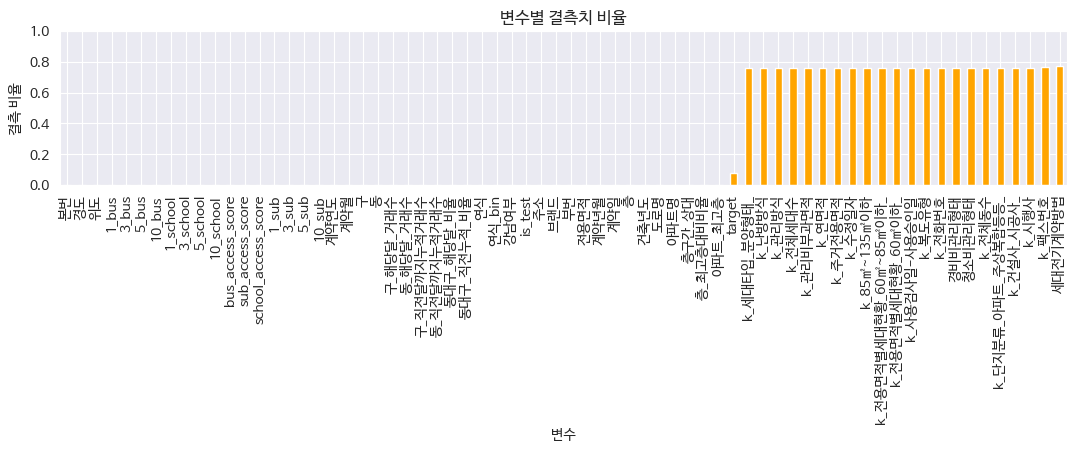

<Axes: title={'center': '변수별 결측치 비율'}, xlabel='변수', ylabel='결측 비율'>

In [30]:
plot_missing_ratio(house_select, min_ratio=0.0, figsize=(13, 2), color='orange', title='변수별 결측치 비율')

In [31]:
house_select.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일-사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60㎡이하_',
       'k_전용면적별세대현황_60㎡~85㎡이하_', 'k_85㎡~135㎡이하', 'k_수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', 'target', 'is_test', '주소', '경도', '위도', '1_bus',
       '3_bus', '5_bus', '10_bus', '1_school', '3_school', '5_school',
       '10_school', 'bus_access_score', 'sub_access_score',
       'school_access_score', '1_sub', '3_sub', '5_sub', '10_sub', '계약연도',
       '계약월', '구', '동', '아파트_최고층', '층_최고층대비비율', '층구간_상대', '구_해당달_거래수',
       '동_해당달_거래수', '구_직전달까지누적거래수', '동_직전달까지누적거래수', '동대구_해당달_비율',
       '동대구_직전누적_비율', '연식', '연식_bin', '강남여부', '브랜드'],
      dtype='object')

In [32]:
house_select.head()

,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,구_해당달_거래수,동_해당달_거래수,구_직전달까지누적거래수,동_직전달까지누적거래수,동대구_해당달_비율,동대구_직전누적_비율,연식,연식_bin,강남여부,브랜드
0,658.0,1.0,개포6차우성,79.97,201712,08,3,1987,언주로 3,아파트,...,683,70,3645,70,0.102489,0.019204,30,노후_20년초과,1,False
1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,아파트,...,683,70,3645,70,0.102489,0.019204,30,노후_20년초과,1,False
2,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,아파트,...,683,70,3645,70,0.102489,0.019204,30,노후_20년초과,1,False
3,658.0,1.0,개포6차우성,79.97,201801,03,4,1987,언주로 3,아파트,...,787,85,2273,4,0.108005,0.001760,31,노후_20년초과,1,False
4,658.0,1.0,개포6차우성,79.97,201801,08,2,1987,언주로 3,아파트,...,787,85,2273,4,0.108005,0.001760,31,노후_20년초과,1,False


In [33]:
house_select.to_csv('house_select.csv', index=False, encoding='utf-8')